# Problem 1

What is $ \lim_{\epsilon\to0} \int_\epsilon^1 x^{-1} \cos(x^{-1} \log x) dx $ ?

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from math import pi
from numpy import cos, log

#### Plot of the integrand on the interval [0,1]

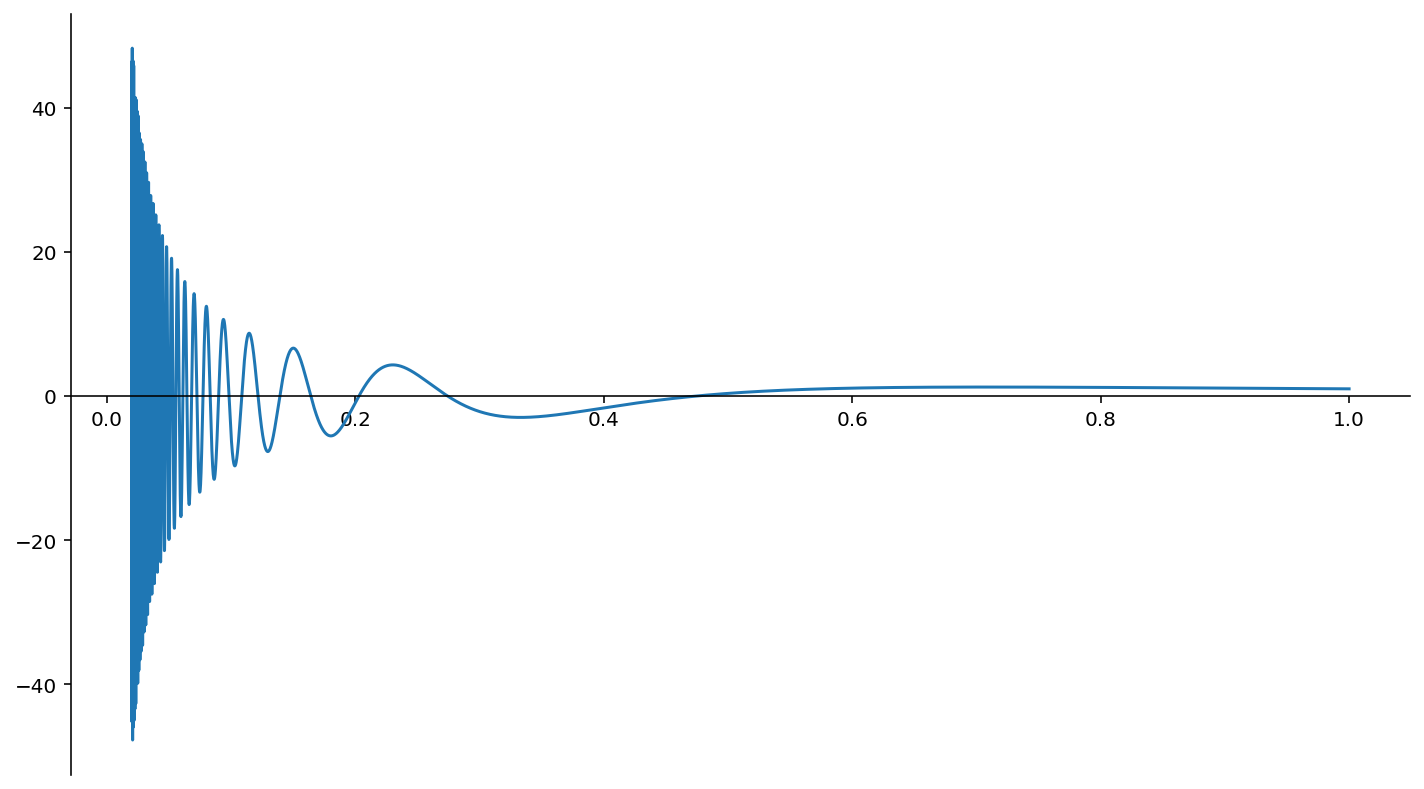

In [ ]:
f = lambda x: cos(log(x)/x)/x
x = np.linspace(0.02,1,10000)[1:]
y = f(x)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.plot(x,y)

As we can see, the integrand is very ill-behaved and oscillates a lot - therefore typical numerical integration algorithms may not work that well. Nonetheless, we will try that as a first attempt.

## Attempt 1: Integrating as is

In [ ]:
from scipy import integrate
integrate.quad(f,0,1)

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  from ipykernel import kernelapp as app


(1.2716741383488144, 1.9276166879370535)

As expected, this does not work (noted by the fact that the error estimate is larger than the value it got for the integral itself) as the integral is not well-behaved. However, what if we try to integrate between the zeros of the function? 

$ \cos(x^{-1} \log{x}) = 0 \implies x^{-1} \log{x} = \pi(n-\frac{1}{2}), n \in \mathbb{Z}, n<0 \implies x = e^{-W(\frac{\pi}{2} - n\pi)}$

where $ W(x) $ is the Lambert W function.

In [ ]:
from scipy.special import lambertw
from scipy.integrate import quad
from numpy import exp
from math import pi
import time
start = time.time()
def nth_zero(n):
    return exp(-lambertw(pi/2-n*pi)).real
total_integral, total_error = quad(f,nth_zero(0),1)
integral_convergents = []
for i in range(0,-1000000,-1):
    next_integral, next_error = quad(f,nth_zero(i-1),nth_zero(i))
    total_integral += next_integral
    total_error += next_error
    if i%50000==0: print(i, total_integral, total_error)
    if i%1000==0: integral_convergents.append(total_integral)
print(i, total_integral, total_error)
print("time elapsed: ", time.time()-start, " seconds")

0 0.2093774868389 8.551574019547362e-13


-50000 0.32336166100763786 9.199969403148974e-13


-100000 0.32336452973372765 9.41045603043285e-13


-150000 0.32336549110532514 9.642288368813775e-13


-200000 0.3233659732471019 9.969676238962813e-13


-250000 0.32336626313970623 1.0337413704109288e-12


-300000 0.32336645671027714 1.063231636894733e-12


-350000 0.3233665951524794 1.1009477312929964e-12


-400000 0.32336669909516663 1.1499512487937676e-12


-450000 0.3233667800133126 1.2049848101093215e-12


-500000 0.3233668447993432 1.2623313758922103e-12


-550000 0.3233668978434139 1.3003435725411591e-12


-600000 0.32336694207463024 1.340737038227552e-12


-650000 0.323366979522359 1.384486101361928e-12


-700000 0.32336701163706966 1.4411810742155746e-12


-750000 0.3233670394830824 1.5049750408295376e-12


-800000 0.323367063859071 1.5720907873329358e-12


-850000 0.3233670853760621 1.6428761189373955e-12


-900000 0.3233671045095672 1.7181240588608689e-12


-950000 0.32336712163513154 1.7980657504737465e-12


-999999 0.32336772630274035 1.8825420419090788e-12
time elapsed:  87.82242798805237  seconds


Convergence seems to be too slow, thus we will use Wynn's epsilon algorithm to extrapolate this sequence

In [ ]:
from mpmath import shanks
%time extrapolated_limit = shanks(integral_convergents)[-1][-1]
extrapolated_limit

CPU times: user 3.86 s, sys: 128 ms, total: 3.98 s
Wall time: 3.99 s


mpf('0.32336728193229802')

Even after all of this, we are only able to get an accuracy of 6 digits. Clearly, we need a different approach

## Attempt 2: Complex integration

We have that
$ \int_0^1 \frac{\cos(x^{-1} \log{x})}{x} dx = \int_0^1 \Re(\frac{e^{i(\log{x}/x)}}{x}) = \int_0^1 \Re(x^{-1+i/x}) = \Re(\int_0^1 x^{-1+i/x}) = \Re(\int_C x^{-1+i/x})$

where C is a contour from 0 to 1 such that the integrand is analytic across the whole contour

Let's use a semicircle oriented counterclockwise centered at 1/2 on the complex plane with a radius of -1/2. This can be parametrized as the following
$ r(\theta) = \frac{1}{2} - \frac{1}{2}e^{-i\theta}, \theta \in [0, \pi]$

Substituting this in, we have our integral is
$ \Re(\int_0^\pi \frac{ie^{-it}}{1-e^{-it}} (\frac{1}{2}[1-e^{-it}])^{\frac{2i}{1-e^{-it}}} dt)$

In [ ]:
ex = lambda t: exp(1j*t)
integrand = lambda t: 1j*ex(-t)/(1-ex(-t)) * (0.5*(1-ex(-t)))**(2j/(1-ex(-t)))
%time integrate.quad(integrand,0,pi)

CPU times: user 805 µs, sys: 3.93 ms, total: 4.73 ms
Wall time: 9.25 ms


/usr/local/lib/python3.6/dist-packages/scipy/integrate/quadpack.py:453: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


(0.3233674316777749, 5.9401671061179114e-09)

And there we go, we get 14 accurate digits around 30,000 times faster than the previous attempt. Can we get more digits? Let's try the above approach but instead using the mpmath python library, a library for arbitrary precision arithmetic

In [ ]:
from mpmath import mp, mpf, mpc, exp, quad, pi
mp.dps = 1000
ex = lambda t: exp(mpc(0,1)*t)
integrand = lambda t: mpc(0,1)*ex(-t)/(1-ex(-t)) * (mpf("0.5")*(1-ex(-t)))**(mpc(0,2)/(1-ex(-t)))
%time result, error = quad(integrand, [0,pi], error=True)
print(result.real, error)

CPU times: user 1min 32s, sys: 447 ms, total: 1min 32s
Wall time: 1min 32s
0.32336743167777876139937008795217044665104662572546966168103644343179033721067289443193037046410245138028052733121715128433295510033435188538143459338499591004962031872302437553058503268678260848141436210082845447223254331974232895622083830360518061381702288759277962238894141948088977862776567200916363254809300626123688307095156172596262271091227961818486264925203544258058783035128789227135061769725043634273242780626981954599359379349487033770039938878958444941938532524701051263491411668692808429670505450842283874069074200475180220172475541092305833604470950458175969464897886301677684260917361445085967504940115969318169715870285721071580528889123103966740195477112287059791090468098755993831428538993148977233485367694543683615578685262852463455374636167870336055419899105303373002905595204909101381319521275325199677051881007836511188772835687475009609176911865529334596642093059266995096076632168382511609990025691

And there we go, 1000 digits of the answer!